### Imports

In [7]:
# Datamanipulation 
import pandas as pd
import numpy as np
import unicodedata
# Working with images
import cv2
from PIL import Image
# Path tools
import glob
import os
# Stringmatching
from fuzzywuzzy import fuzz
# Vizualization
from matplotlib import pyplot as plt
import json

### Functions

In [2]:
def win_compare_frames_screenshot_with_matchTemplate(video_path, screenshot_path):
    """For a given video and screenshot, this function returns the frame of the video 
    with the highest similarity to the screenshot using OpenCV matchTemplate. Includes Pillow 
    because of special character issues in openCV Library"""
    
    # Use Pillow to load the screenshot and convert it to grayscale
    pillow_image = Image.open(screenshot_path).convert("L")  # Convert to grayscale
    screenshot = np.array(pillow_image)  # Convert Pillow image to NumPy array
    
    video = cv2.VideoCapture(video_path)
    highest_match_score = 0
    highscore_frame = 0

    for i in range(0, int(video.get(cv2.CAP_PROP_FRAME_COUNT))):
        video.set(cv2.CAP_PROP_POS_FRAMES, i)
        success, extracted_frame = video.read()

        if not success:
            print(f"Warning: Could not read frame {i}")
            continue
        
        # Convert the extracted frame to grayscale
        extracted_frame_gray = cv2.cvtColor(extracted_frame, cv2.COLOR_BGR2GRAY)

        # Match template
        result = cv2.matchTemplate(extracted_frame_gray, screenshot, cv2.TM_CCOEFF_NORMED)
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)

        if max_val > highest_match_score:
            highest_match_score = max_val
            highscore_frame = i

    print(f"Frame number: {highscore_frame} has the highest score with: {highest_match_score}")
    
    return highest_match_score, highscore_frame

def plot_frame(image):
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # Plot the image with matplotlib
    plt.imshow(image_rgb)
    plt.axis('off')  # Turn off axis
    plt.title("Image from OpenCV")
    plt.show()

def contains_umlaut_or_sharp_s(s):
    umlauts_and_sharp_s = set("äöüÄÖÜß")
    normalized_string = unicodedata.normalize("NFC", s)
    return any(char in umlauts_and_sharp_s for char in normalized_string)

### Sort, filter and structure videos and images

In [3]:
#path_to_images = "/Volumes/ThesisUSB/AVP XC Skiing Data/Skating 2-1 armswing/pictures/lateral/"
path_to_images = "D:\\AVP XC Skiing Data\\Skating 2-1 armswing\\pictures\\lateral\\"
skier_images = glob.glob(path_to_images + "*.jpg") + glob.glob(path_to_images + "*.png")

#path_to_videos = "/Volumes/ThesisUSB/AVP XC Skiing Data/Skating 2-1 armswing/videos/lateral/"
path_to_videos = "D:\\AVP XC Skiing Data\\Skating 2-1 armswing\\videos\\lateral\\" 
skier_videos = glob.glob(path_to_videos + "*.[mM][pP]4") + glob.glob(path_to_videos + "*.[mM][oO][vV]")
skier_videos = [video for video in skier_videos if "_lq" not in video] # exclude all videos containing "_lq" to avoid double videos

image_file_names = []
video_file_names = []

for image_path in skier_images:
    file_name_with_extension = os.path.basename(image_path)
    image_file_names.append(file_name_with_extension)

for video_path in skier_videos:
    file_name_with_extension = os.path.basename(video_path)
    video_file_names.append(file_name_with_extension)


### Generation of a dictionary containing video names (keys) with 5 matching label imagenames (values) 

In [4]:
videos_and_images_dict = {}

for video_string in video_file_names:
    images_per_vid_dict = {}
    for image_string in image_file_names:
        score = fuzz.ratio(video_string, image_string) # fuzzywuzzy used to compare simmilarity of strings
        images_per_vid_dict[image_string] = score

    top_5 = dict(sorted(images_per_vid_dict.items(), key=lambda item: item[1], reverse=True)[:5])
    key_list = list(top_5.keys())

    videos_and_images_dict[video_string] = key_list

### Demo of TemplateMatching

Frame number: 71 has the highest score with: 0.9990189075469971


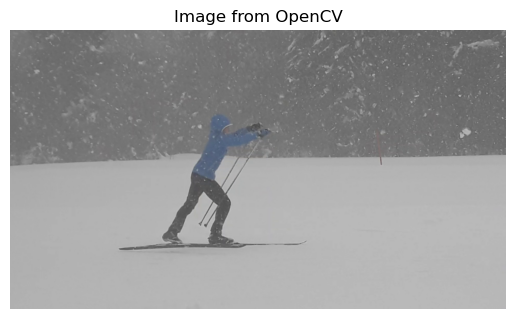

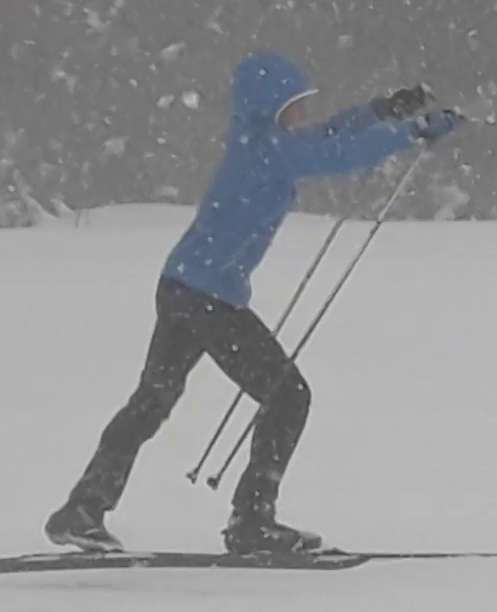

In [17]:
path_to_example_screenshot = path_to_images + videos_and_images_dict['Göpfert Haile.mp4'][1]
path_to_frame = path_to_videos + "Göpfert Haile.mp4"

example_score, example_frame = win_compare_frames_screenshot_with_matchTemplate(path_to_frame, path_to_example_screenshot)

screenshot = Image.open(path_to_example_screenshot)

test_cap = cv2.VideoCapture(path_to_frame)
test_cap.set(cv2.CAP_PROP_POS_FRAMES, example_frame)
ret, extracted_frame = test_cap.read()

plot_frame(extracted_frame)
screenshot

In [ ]:
path_to_example_screenshot

'D:\\AVP XC Skiing Data\\Skating 2-1 armswing\\pictures\\lateral\\Göpfert Haile _005.jpg'

### Generation of dict containing Video and Label Frames 
- Iteration over videos_and_images_dict to find the highscoreframe which is the full label frame 

In [19]:
label_frames_dict = {
    "videos": []
}

for key, value in videos_and_images_dict.items():
    print(f"Processing video: {key}")

    single_video_dict = {
        "videoname": key,
        "frame_details": []
    }

    for screenshot in range(len(value)):
        print(f"Processing screenshot {screenshot} for video {key}")
        
        frame_detail_dict = {}
        path_to_frame = path_to_videos + key
        path_to_screenshot = path_to_images + videos_and_images_dict[key][screenshot]

        print(f"Path to frame: {path_to_frame}")
        print(f"Path to screenshot: {path_to_screenshot}")
        
        highest_match_score, highscore_frame = win_compare_frames_screenshot_with_matchTemplate(path_to_frame, path_to_screenshot)
        print(f"Match score: {highest_match_score}, High score frame: {highscore_frame}")

        frame_detail_dict["frame_number"] = highscore_frame
        frame_detail_dict["score"] = highest_match_score
        frame_detail_dict["image_name"] = videos_and_images_dict[key][screenshot]

        single_video_dict["frame_details"].append(frame_detail_dict)
    
    label_frames_dict["videos"].append(single_video_dict)


# Default JSON file path

json_file_path = "D:\\AVP XC Skiing Data\\Skating 2-1 armswing\\labelFrames.json"

if os.path.exists(json_file_path):
    print(f"File {json_file_path} already exists.")
    new_file_name = input("Enter a new filename (or press Enter to overwrite): ").strip()
    if new_file_name:
        json_file_path = os.path.join(os.path.dirname(json_file_path), new_file_name)
    else:
        print(f"Overwriting existing file: {json_file_path}")


with open(json_file_path, "w") as json_file:
    json.dump(label_frames_dict, json_file, indent=4)

print(f"JSON file saved at: {json_file_path}")

Processing video: Klauser Hannes.mp4
Processing screenshot 0 for video Klauser Hannes.mp4
Path to frame: D:\AVP XC Skiing Data\Skating 2-1 armswing\videos\lateral\Klauser Hannes.mp4
Path to screenshot: D:\AVP XC Skiing Data\Skating 2-1 armswing\pictures\lateral\Klauser Hannes_004.jpg
Frame number: 42 has the highest score with: 0.9994391798973083
Match score: 0.9994391798973083, High score frame: 42
Processing screenshot 1 for video Klauser Hannes.mp4
Path to frame: D:\AVP XC Skiing Data\Skating 2-1 armswing\videos\lateral\Klauser Hannes.mp4
Path to screenshot: D:\AVP XC Skiing Data\Skating 2-1 armswing\pictures\lateral\Klauser Hannes_005.jpg
Frame number: 65 has the highest score with: 0.9995198845863342
Match score: 0.9995198845863342, High score frame: 65
Processing screenshot 2 for video Klauser Hannes.mp4
Path to frame: D:\AVP XC Skiing Data\Skating 2-1 armswing\videos\lateral\Klauser Hannes.mp4
Path to screenshot: D:\AVP XC Skiing Data\Skating 2-1 armswing\pictures\lateral\Klause

In [20]:
with open(json_file_path, "r") as file:
    json_file = json.load(file)

df = pd.json_normalize(
    json_file["videos"],
    record_path="frame_details",
    meta=["videoname"],
    sep="_"
)

In [21]:
df

,frame_number,score,image_name,videoname
0,42,0.999439,Klauser Hannes_004.jpg,Klauser Hannes.mp4
1,65,0.999520,Klauser Hannes_005.jpg,Klauser Hannes.mp4
2,29,0.999417,Klauser Hannes_001.jpg,Klauser Hannes.mp4
3,32,0.999442,Klauser Hannes_002.jpg,Klauser Hannes.mp4
4,37,0.999476,Klauser Hannes_003.jpg,Klauser Hannes.mp4
...,...,...,...,...
150,57,0.999403,Uhlig Niklas_003.jpg,Uhlig Niklas.MOV
151,39,0.999539,Uhlig Niklas_002.jpg,Uhlig Niklas.MOV
152,36,0.999554,Uhlig Niklas_001.jpg,Uhlig Niklas.MOV
153,84,0.958294,Uhlig Niklas_005.jpg,Uhlig Niklas.MOV


In [22]:
output_directory = r"D:\AVP XC Skiing Data\Skating 2-1 armswing\extracted_frames"

os.makedirs(output_directory, exist_ok=True)

for i in range(len(df)):
    if df["score"][i] != 0:
        current_frame = df["frame_number"][i]
        current_video = os.path.join(path_to_videos, df["videoname"][i])  # Ensure Windows path
        current_image_name = df["image_name"][i]
        filename_without_extension = os.path.splitext(current_image_name)[0]

        output_frame_path = os.path.join(output_directory, f"{filename_without_extension}.jpg")

        cap = cv2.VideoCapture(current_video)
        cap.set(cv2.CAP_PROP_POS_FRAMES, current_frame)
        ret, extracted_frame = cap.read()

        if ret:
            # Save the extracted frame as a JPEG image
            cv2.imwrite(output_frame_path, extracted_frame)
            print(f"Saved: {output_frame_path}")
        else:
            print(f"Failed to extract frame {current_frame} from {current_video}")

        cap.release()

Saved: D:\AVP XC Skiing Data\Skating 2-1 armswing\extracted_frames\Klauser Hannes_004.jpg
Saved: D:\AVP XC Skiing Data\Skating 2-1 armswing\extracted_frames\Klauser Hannes_005.jpg
Saved: D:\AVP XC Skiing Data\Skating 2-1 armswing\extracted_frames\Klauser Hannes_001.jpg
Saved: D:\AVP XC Skiing Data\Skating 2-1 armswing\extracted_frames\Klauser Hannes_002.jpg
Saved: D:\AVP XC Skiing Data\Skating 2-1 armswing\extracted_frames\Klauser Hannes_003.jpg
Saved: D:\AVP XC Skiing Data\Skating 2-1 armswing\extracted_frames\Niemeyer Felix _005.jpg
Saved: D:\AVP XC Skiing Data\Skating 2-1 armswing\extracted_frames\Niemeyer Felix _004.jpg
Saved: D:\AVP XC Skiing Data\Skating 2-1 armswing\extracted_frames\Niemeyer Felix _003.jpg
Saved: D:\AVP XC Skiing Data\Skating 2-1 armswing\extracted_frames\Niemeyer Felix _002.jpg
Saved: D:\AVP XC Skiing Data\Skating 2-1 armswing\extracted_frames\Niemeyer Felix _001.jpg
Saved: D:\AVP XC Skiing Data\Skating 2-1 armswing\extracted_frames\Müller Jonah_001.jpg
Saved: 